In [356]:
import pandas as pd
import numpy as np
import requests
import os
from random import sample
import re
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Gather

Code for downloading Udacity's Dog Prediction Data

In [2]:
#url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
#r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [3]:
# make a directory if one does not already exist
#folder_name = 'dog_predictions'
#if not os.path.exists(folder_name):
    #os.makedirs(folder_name)

In [4]:
#with open(os.path.join(folder_name, 
                           #url.split('/')[-1]), mode='wb') as file:
             #file.write(r.content)

Initializing All Relevant Datasets

In [5]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive;

In [6]:
predicts = pd.read_csv('dog_predictions/image-predictions.tsv', sep='\t')
predicts;

In [7]:
twitter_api = pd.read_csv('twitter_api_data.csv')
twitter_api;

# Assess

### Documented Issues

`twitter_archive`
#### Quality
- timestamp is a string and not datetime
- text column irrelevant material
- 137 duplicate posts, possible because they are reposted? many duplicates have the tag "RT @dog_rates: " before
- texts must be stripped of "RT @dog_rates: "
- There are 42 instances where categorical variables are found in the text, but are not accurately accounted for in the categorical columns
- There are 109 instances where the name column is not accurate, (ex: index 542 name is considered "incredibly" since text before contains "incredible"), and an incorrect name is in place.
    - I recognize that it is an oversight that I cannot test whether or not a name is missed because I do not yet have knowledge of a language processing library.
- Missing rows in "in_reply_to_status_id" "in_reply_to_user_id" "retweeted_status_id" "retweeted_status_user_id" "retweeted_status_timestamp"
- Ratings may contain floats. Texts needs to be checked again
- change id to string
- drop expanded url and source, as they are incomplete and not useful for analysis

#### Tidiness
- text column contains a source variable for the tweet
- dog "ages/types" (floofer, pupper etc.) should be single, categorial column

`predicts`
#### Quality
- prediction dog breeds have inconsistent casing
- column titles should be be full names
- change id to string
- extract predictions for images where predictions are both dogs and above 70% confidence
    - If our confidence level is too low, then our statements become less meaningful. However, because I am not sure how to test the accuracy of the predictions, I will choose a lowish confidence level since I am aware that many of the pictures will contain dogs.

#### Tidiness
 

`twitter_api`
#### Quality
- change id to string (should have done this when extracting)
- change retweet and favorite to int

#### Tidiness
- tables need to be reorganized
    - 1 for souce metadata (urls

In [8]:
pd.set_option('display.max_colwidth', -1)

### twitter_archive

#### Visual Assessment

In [9]:
#to be used for visual assessments. Supressed to save space.
twitter_archive.sample(5);

In [10]:
twitter_archive.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [11]:
#no duplicated values
list(twitter_archive.text.duplicated()).count(True)

0

In [12]:
#to be used for visual assessments. commented out to save space
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
#investigating max values for numerator/denominator
twitter_archive.describe();

#### Function(s) used for progrmattic assessment

In [14]:
def category_accuracy(df, columns_list):
    '''category_accuracy parses through the texts column of a dataframe and checks if the information matches
    the values of the categorical columns, GIVEN that the text is used as the categorical variable source
    and categorical column values are the same as column header.
    Restrictions: text column must be called "text".
    Returns: category_accuracy returns the index of rows where the categorical values do not match the text'''
    offending_rows = []
    # matching text with other columns
    #itterate through df
    for index, row in df.iterrows():
        match = []
        #current values in columns
        secondary = [row[column] for column in columns_list]
        #going through every word and checking for classification qualification
        source = row.text.split()
        for word in source:
            match += [value for value in columns_list if value in word and pd.notnull(word) and word != 'None']
    #checking for accuracy
        #if there was more than one match, was it accurate?
        if len(match)> 0:
            test = []
            #this loops checks to see if the row value is the same as the matched value
            for current in secondary:
                for i in match:
                    test.append(i == current)
            # if there are less correct than actual matches, then there is an inaccurate column.
            if test.count(True) < len(match):
                offending_rows.append(index)
    return offending_rows

### Parsing Text for Accuracy

In [15]:
#category_accuracy(df, columns)
offending_categorical_rows = category_accuracy(twitter_archive, ['doggo', 'floofer', 'pupper', 'puppo'])
print('The number of instances where doggo, floofer, pupper, and puppo is found in the text, but does not have the correct value is: ', len(offending_categorical_rows))

The number of instances where doggo, floofer, pupper, and puppo is found in the text, but does not have the correct value is:  42


In [16]:
print('The list of offending rows: ', offending_categorical_rows)

The list of offending rows:  [54, 83, 85, 106, 134, 172, 228, 268, 274, 296, 302, 475, 477, 545, 798, 934, 946, 987, 993, 1027, 1093, 1120, 1220, 1228, 1254, 1265, 1351, 1516, 1634, 1635, 1636, 1643, 1710, 1712, 1743, 1826, 1843, 1847, 1862, 1900, 1928, 2141]


In [17]:
#investigate offending rows. Rows had issues. Code has been commented out to save space.
#for i in offending_categorical_rows:
    #display(twitter_archive[twitter_archive.index == i])

### Checking Names Column

Since names are capitalized, names that are lowercase will be flagged as they will likely not be actual names.

In [18]:
#demonstrating regular names
regular_names = []
for name in twitter_archive.name:
    if name[0].isupper() and name != 'None' and pd.notnull(name):
        regular_names.append(name)
sample(regular_names, 20)

['Nico',
 'Toby',
 'Rubio',
 'Rusty',
 'Calvin',
 'Lucy',
 'Wesley',
 'Mookie',
 'Scooter',
 'Chester',
 'Bubbles',
 'Dug',
 'Eve',
 'Ellie',
 'Tito',
 'Geoff',
 'Wyatt',
 'Mac',
 'Maximus',
 'Lennon']

In [19]:
#flagging lowercase names and index
incorrect_names = []
for index, row in twitter_archive.iterrows():
    if row['name'][0].islower() and row['name'] != 'None' and pd.notnull(row['name']):
        incorrect_names.append((row['name'], index))
incorrect_names
#len(incorrect_names) returns 109 instances

[('such', 22),
 ('a', 56),
 ('quite', 118),
 ('quite', 169),
 ('quite', 193),
 ('not', 335),
 ('one', 369),
 ('incredibly', 542),
 ('a', 649),
 ('mad', 682),
 ('an', 759),
 ('very', 773),
 ('a', 801),
 ('very', 819),
 ('just', 822),
 ('my', 852),
 ('one', 924),
 ('not', 988),
 ('his', 992),
 ('one', 993),
 ('a', 1002),
 ('a', 1004),
 ('a', 1017),
 ('an', 1025),
 ('very', 1031),
 ('actually', 1040),
 ('a', 1049),
 ('just', 1063),
 ('getting', 1071),
 ('mad', 1095),
 ('very', 1097),
 ('this', 1120),
 ('unacceptable', 1121),
 ('all', 1138),
 ('a', 1193),
 ('old', 1206),
 ('a', 1207),
 ('infuriating', 1259),
 ('a', 1340),
 ('a', 1351),
 ('a', 1361),
 ('an', 1362),
 ('a', 1368),
 ('a', 1382),
 ('very', 1385),
 ('getting', 1435),
 ('just', 1457),
 ('a', 1499),
 ('the', 1527),
 ('the', 1603),
 ('actually', 1693),
 ('by', 1724),
 ('a', 1737),
 ('officially', 1747),
 ('a', 1785),
 ('the', 1797),
 ('the', 1815),
 ('a', 1853),
 ('a', 1854),
 ('a', 1877),
 ('a', 1878),
 ('life', 1916),
 ('a', 1923

## predicts

In [20]:
predicts.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
266,670804601705242624,https://pbs.twimg.com/media/CU8tOJZWUAAlNoF.jpg,1,Pomeranian,0.868560,True,Pekinese,0.090129,True,chow,0.021722,True
838,694352839993344000,https://pbs.twimg.com/media/CaLWOPfWkAAo2Dt.jpg,2,Australian_terrier,0.407886,True,Yorkshire_terrier,0.328173,True,silky_terrier,0.108404,True
1898,850753642995093505,https://pbs.twimg.com/media/C8576jrW0AEYWFy.jpg,1,pug,0.996952,True,bull_mastiff,0.000996,True,French_bulldog,0.000883,True
1406,770069151037685760,https://pbs.twimg.com/media/Cq_Vy9KWcAIUIuv.jpg,1,Boston_bull,0.414965,True,American_Staffordshire_terrier,0.286985,True,Staffordshire_bullterrier,0.114970,True
1164,735256018284875776,https://pbs.twimg.com/media/CjQnclkVEAA4pnK.jpg,1,Staffordshire_bullterrier,0.523191,True,French_bulldog,0.351104,True,doormat,0.028075,False


In [21]:
predicts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## twitter_api

In [22]:
twitter_api.sample(5)

,id,favorite_count,retweet_count,expanded_url
941,752932432744185856,13025,7095,https://vine.co/v/OEppMFbejFz
1166,722613351520608256,5068,1666,https://twitter.com/dog_rates/status/722613351520608256/photo/1
1704,680889648562991104,1803,375,https://twitter.com/dog_rates/status/680889648562991104/photo/1
266,841833993020538882,0,15535,https://twitter.com/dog_rates/status/817423860136083457/video/1
1181,719332531645071360,3491,973,https://twitter.com/dog_rates/status/719332531645071360/photo/1


In [23]:
twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
id                2356 non-null int64
favorite_count    2356 non-null object
retweet_count     2356 non-null object
expanded_url      2299 non-null object
dtypes: int64(1), object(3)
memory usage: 73.7+ KB


# Clean

Creating Cleaning Copies

In [24]:
twitter_archive_clean = twitter_archive.copy()

In [25]:
predicts_clean = predicts.copy()

In [26]:
twitter_api_clean = twitter_api.copy()

### Twitter Archive

#### Quality
- timestamp is a string and not datetime
- text column irrelevant material
- 137 duplicate posts, possible because they are reposted? many duplicates have the tag "RT @dog_rates: " before
- texts must be stripped of "RT @dog_rates: "
- There are 42 instances where categorical variables are found in the text, but are not accurately accounted for in the categorical columns
- There are 109 instances where the name column is not accurate, (ex: index 542 name is considered "incredibly" since text before contains "incredible"), and an incorrect name is in place.
    - I recognize I cannot test whether or not a name is missed because I do not have knowledge of a language processing library. Thus there may be names that are incorrect but undetectable
- Missing rows in "in_reply_to_status_id" "in_reply_to_user_id" "retweeted_status_id" "retweeted_status_user_id" "retweeted_status_timestamp"
- Ratings may contain floats. Texts needs to be checked again
- change id to string
- drop expanded url and source, as they are incomplete and not useful for analysis
- tweet_id: 881633300179243008 contains two ratings, the latter is the correct one

#### Tidiness
- text column contains a source variable for the tweet
- dog "ages/types" (floofer, pupper etc.) should be single, categorial column

#### Define 
Use astype to change timestamp to timedate

#### Code

In [27]:
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive.timestamp)

#### Test

In [28]:
#timestamp was successfully changed to datetime, commented for space
#twitter_archive_clean.info()

#### Define
Use str.replace to remove unwanted url from text column

#### Code

In [29]:
#testing
twitter_archive.text[0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [30]:
#regex citation: https://stackoverflow.com/questions/6038061/regular-expression-to-find-urls-within-a-string
#regex expression has been altered to work with the dataset (elipses and other perumutations have been added)
#includes characacters :// 
#([\w_-]+(?:(?:\.[\w_-]+)+))groups combonations of "alphanumeric.alphanumeric"
#([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])? groups combonations of alphanumeric and special symbols
text = re.sub(r'(\\n\\nhttps|http|ftp|https)([:…/]+)([\w_…-]*(?:(?:\.[\w_…-]*)*))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-…]*)?', '', twitter_archive.text[0], flags = re.MULTILINE)
text

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 "

In [31]:
twitter_archive_clean.text = twitter_archive_clean.text.str.replace(r'(\\n\\nhttps|http|ftp|https)([:…/]+)([\w_…-]*(?:(?:\.[\w_…-]*)*))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-…]*)?', '');

#### Test

In [32]:
[i for i in twitter_archive_clean.text if 'https' in i]

[]

In [33]:
#urls removed, supressed for space
twitter_archive_clean.text;

In [34]:
twitter_archive_clean.sample(5);

#### Define
Remove "RT @dog_rates: " replace

#### Code

In [35]:
twitter_archive_clean.text = twitter_archive_clean.text.str.replace(r'(RT @dog_rates: )', '');

#### Test

In [36]:
for i in twitter_archive_clean.text:
    if 'RT @dog_rates: ' in i:
        print(i)

#### Define
Drop Duplicates tweets. Although they might have different meta data, they are still the same "tweet" and having duplicates will alter the analysis

#### Code

In [37]:
#investigate duplicates?
list(twitter_archive_clean.text.duplicated()).count(True)

137

In [38]:
#dropping all duplicates based on text data
twitter_archive_clean.drop_duplicates('text', keep = 'first', inplace = True)
twitter_archive_clean.reset_index(inplace = True)

#### Test

In [39]:
#former shape was 2356. 2356 - 2219 = 137
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 18 columns):
index                         2219 non-null int64
tweet_id                      2219 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2219 non-null datetime64[ns, UTC]
source                        2219 non-null object
text                          2219 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2160 non-null object
rating_numerator              2219 non-null int64
rating_denominator            2219 non-null int64
name                          2219 non-null object
doggo                         2219 non-null object
floofer                       2219 non-null object
pupper                        2219 non-null object
puppo               

#### Define
Investigate and fix innacurate classification, using modified categorical_accuracy function

#### Code

In [40]:
for i in offending_categorical_rows:
    display(twitter_archive_clean[twitter_archive_clean.index == i])

,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
54,55,881633300179243008,8.816070e+17,47384430.0,2017-07-02 21:58:53+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
83,85,876120275196170240,NaN,NaN,2017-06-17 16:52:05+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Venti, a seemingly caffeinated puppoccino. She was just informed the weekend would include walks, pats and scritches. 13/10 much excite",NaN,NaN,NaN,https://twitter.com/dog_rates/status/876120275196170240/photo/1,13,10,Venti,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
85,87,875144289856114688,NaN,NaN,2017-06-15 00:13:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Nugget and Hank. Nugget took Hank's bone. Hank is wondering if you would please return it to him. Both 13/10 would not intervene,NaN,NaN,NaN,https://twitter.com/dog_rates/status/875144289856114688/video/1,13,10,Nugget,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
106,108,871515927908634625,NaN,NaN,2017-06-04 23:56:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Napolean. He's a Raggedy East Nicaraguan Zoom Zoom. Runs on one leg. Built for deception. No eyes. Good with kids. 12/10 great doggo,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/871515927908634625/photo/1,https://twitter.com/dog_rates/status/871515927908634625/photo/1",12,10,Napolean,doggo,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
134,139,865359393868664832,NaN,NaN,2017-05-19 00:12:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sammy. Her tongue ejects without warning sometimes. It's a serious condition. Needs a hefty dose from a BlepiPen. 13/10,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/865359393868664832/photo/1,https://twitter.com/dog_rates/status/865359393868664832/photo/1",13,10,Sammy,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
172,177,857393404942143489,NaN,NaN,2017-04-27 00:38:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Instead of the usual nightly dog rate, I'm sharing this story with you. Meeko is 13/10 and would like your help \n\n",NaN,NaN,NaN,"https://www.gofundme.com/meeko-needs-heart-surgery,https://twitter.com/dog_rates/status/857393404942143489/photo/1,https://twitter.com/dog_rates/status/857393404942143489/photo/1,https://twitter.com/dog_rates/status/857393404942143489/photo/1,https://twitter.com/dog_rates/status/857393404942143489/photo/1",13,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
228,233,847842811428974592,NaN,NaN,2017-03-31 16:07:33+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Rontu. He is described as a pal, cuddle bug, protector and constant shadow. 12/10, but he needs your help\n\n",NaN,NaN,NaN,"https://www.gofundme.com/help-save-rontu,https://twitter.com/dog_rates/status/847842811428974592/photo/1",12,10,Rontu,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
268,274,840698636975636481,8.406983e+17,8.405479e+17,2017-03-11 22:59:09+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@0_kelvin_0 &gt;10/10 is reserved for puppos sorry Kevin,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
274,280,839549326359670784,NaN,NaN,2017-03-08 18:52:12+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Winston. He knows he's a little too big for the swing, but he doesn't care. Kindly requests a push. 12/10 would happily oblige",NaN,NaN,NaN,https://twitter.com/dog_rates/status/839549326359670784/photo/1,12,10,Winston,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
296,303,836397794269200385,NaN,NaN,2017-02-28 02:09:08+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Buddy. He ran into a glass door once. Now he's h*ckin skeptical. 13/10 empowering af (vid by Brittany Gaunt),8.178278e+17,4.196984e+09,2017-01-07 20:18:46 +0000,https://twitter.com/dog_rates/status/817827839487737858/video/1,13,10,Buddy,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
302,309,835536468978302976,NaN,NaN,2017-02-25 17:06:32+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Lola. Her hobbies include being precious af and using her foot as a toothbrush. 12/10 Lola requests your help\n\n,8.352641e+17,4.196984e+09,2017-02-24 23:04:14 +0000,"https://www.gofundme.com/lolas-life-saving-surgery-funds,https://twitter.com/dog_rates/status/835264098648616962/photo/1,https://twitter.com/dog_rates/status/835264098648616962/photo/1",12,10,Lola,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
475,497,813142292504645637,NaN,NaN,2016-12-25 22:00:04+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Everybody stop what you're doing and look at this dog with her tiny Santa hat. 13/10,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/813142292504645637/photo/1,https://twitter.com/dog_rates/status/813142292504645637/photo/1,https://twitter.com/dog_rates/status/813142292504645637/photo/1",13,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
477,499,813127251579564032,NaN,NaN,2016-12-25 21:00:18+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's an anonymous doggo that appears to be very done with Christmas. 11/10 cheer up pup,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/813127251579564032/photo/1,https://twitter.com/dog_rates/status/813127251579564032/photo/1",11,10,None,doggo,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
545,572,801285448605831168,NaN,NaN,2016-11-23 04:45:12+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",oh h*ck 10/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801285448605831168/photo/1,10,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
798,869,761745352076779520,NaN,NaN,2016-08-06 02:06:59+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Guys.. we only rate dogs. Pls don't send any more pics of the Loch Ness Monster. Only send in dogs. Thank you. 11/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/761745352076779520/photo/1,11,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
934,1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459439529985/photo/1,0,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
946,1029,745712589599014916,NaN,NaN,2016-06-22 20:18:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Percy. He fell asleep at the wheel. Irresponsible af. 7/10 absolute menace on the roadway,NaN,NaN,NaN,https://twitter.com/dog_rates/status/745712589599014916/photo/1,7,10,Percy,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
987,1075,739623569819336705,NaN,NaN,2016-06-06 01:02:55+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Here's a doggo that don't need no human. 12/10 independent af (vid by @MichelleLiuCee),NaN,NaN,NaN,https://vine.co/v/iY9Fr1I31U6,12,10,None,doggo,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
993,1083,738537504001953792,NaN,NaN,2016-06-03 01:07:16+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bayley. She fell asleep trying to escape her evil fence enclosure. 11/10 night night puppo,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/738537504001953792/photo/1,https://twitter.com/dog_rates/status/738537504001953792/photo/1",11,10,Bayley,None,None,None,puppo


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1027,1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1093,1188,718454725339934721,NaN,NaN,2016-04-08 15:05:29+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This pic is old but I hadn't seen it until today and had to share. Creative af. 13/10 very good boy, would pet well",NaN,NaN,NaN,https://twitter.com/dog_rates/status/718454725339934721/photo/1,13,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1120,1215,715009755312439296,NaN,NaN,2016-03-30 02:56:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Siba. She's remarkably mobile. Very sleepy as well. 12/10 would happily transport,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715009755312439296/photo/1,12,10,Siba,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1220,1319,706516534877929472,NaN,NaN,2016-03-06 16:27:23+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please enjoy this pup in a cooler. Permanently ready for someone to throw a tennis ball his way. 12/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/706516534877929472/photo/1,12,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1228,1327,705975130514706432,NaN,NaN,2016-03-05 04:36:02+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Adele. Her tongue flies out of her mouth at random. It's a debilitating illness. 10/10 stay strong pupper,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/705975130514706432/photo/1,https://twitter.com/dog_rates/status/705975130514706432/photo/1",10,10,Adele,None,None,pupper,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1254,1354,703631701117943808,NaN,NaN,2016-02-27 17:24:05+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bella. Based on this picture she's at least 8ft tall (wow)! Must be rare. 11/10 would pet on tippy toes,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/703631701117943808/photo/1,https://twitter.com/dog_rates/status/703631701117943808/photo/1,https://twitter.com/dog_rates/status/703631701117943808/photo/1,https://twitter.com/dog_rates/status/703631701117943808/photo/1",11,10,Bella,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1265,1366,702671118226825216,NaN,NaN,2016-02-25 01:47:04+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Rambo &amp; Kiwi. Rambo's the pup with the sharp toes &amp; rad mohawk. One stays woke while one sleeps. 10/10 for both,NaN,NaN,NaN,https://twitter.com/dog_rates/status/702671118226825216/photo/1,10,10,Rambo,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1351,1456,695314793360662529,NaN,NaN,2016-02-04 18:35:39+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Colin. He really likes green beans. It's tearing his family apart. 10/10 please pray for Colin,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/695314793360662529/photo/1,https://twitter.com/dog_rates/status/695314793360662529/photo/1,https://twitter.com/dog_rates/status/695314793360662529/photo/1,https://twitter.com/dog_rates/status/695314793360662529/photo/1",10,10,Colin,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1516,1627,684594889858887680,NaN,NaN,2016-01-06 04:38:35+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""FOR THE LAST TIME I DON'T WANNA PLAY TWISTER ALL THE SPOTS ARE GREY DAMN IT CINDY"" ...10/10",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684594889858887680/photo/1,10,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1634,1755,678774928607469569,NaN,NaN,2015-12-21 03:12:08+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tug. He's not required to wear the cone he just wants his voice to project more clearly. 11/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678774928607469569/photo/1,11,10,Tug,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1635,1756,678767140346941444,NaN,NaN,2015-12-21 02:41:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Mia. She makes awful decisions. 8/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678767140346941444/photo/1,8,10,Mia,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1636,1757,678764513869611008,NaN,NaN,2015-12-21 02:30:45+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Wilson. He got caught humping the futon. He's like ""dude, help me out here"" 10/10 I'd help Wilson out",NaN,NaN,NaN,https://twitter.com/dog_rates/status/678764513869611008/photo/1,10,10,Wilson,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1643,1764,678424312106393600,NaN,NaN,2015-12-20 03:58:55+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Crystal. She's a shitty fireman. No sense of urgency. People could be dying Crystal. 2/10 just irresponsible,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678424312106393600/photo/1,2,10,Crystal,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1710,1832,676191832485810177,NaN,NaN,2015-12-14 00:07:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",These two pups just met and have instantly bonded. Spectacular scene. Mesmerizing af. 10/10 and 7/10 for blue dog,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/676191832485810177/photo/1,https://twitter.com/dog_rates/status/676191832485810177/photo/1,https://twitter.com/dog_rates/status/676191832485810177/photo/1",10,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1712,1834,676121918416756736,NaN,NaN,2015-12-13 19:30:01+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Here we are witnessing a very excited dog. Clearly has no control over neck movements. 8/10 would still pet,NaN,NaN,NaN,https://vine.co/v/iZXg7VpeDAv,8,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1743,1867,675334060156301312,NaN,NaN,2015-12-11 15:19:21+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Good morning here's a grass pupper. 12/10,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/675334060156301312/photo/1,https://twitter.com/dog_rates/status/675334060156301312/photo/1",12,10,None,None,None,pupper,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1826,1951,673686845050527744,NaN,NaN,2015-12-07 02:13:55+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is George. He's upset that the 4th of July isn't everyday. 11/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673686845050527744/photo/1,11,10,George,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1843,1969,673317986296586240,NaN,NaN,2015-12-06 01:48:12+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Take a moment and appreciate how these two dogs fell asleep. Simply magnificent. 10/10 for both,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/673317986296586240/photo/1,https://twitter.com/dog_rates/status/673317986296586240/photo/1",10,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1847,1974,673148804208660480,NaN,NaN,2015-12-05 14:35:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Fletcher. He's had a ruff night. No more Fireball for Fletcher. 8/10 it'll be over soon pupper,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673148804208660480/photo/1,8,10,Fletcher,None,None,pupper,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1862,1989,672828477930868736,NaN,NaN,2015-12-04 17:23:04+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jerry. He's a Timbuk Slytherin. Eats his pizza from the side first. Crushed that cup with his bare paws 9/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672828477930868736/photo/1,9,10,Jerry,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1900,2028,671866342182637568,NaN,NaN,2015-12-02 01:39:53+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Dylan. He can use a fork but clearly can't put on a sweatshirt correctly. Looks like a disgruntled teen. 10/10,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671866342182637568/photo/1,10,10,Dylan,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1928,2056,671357843010908160,NaN,NaN,2015-11-30 15:59:17+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Tfw she says hello from the other side. 9/10,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/671357843010908160/photo/1,https://twitter.com/dog_rates/status/671357843010908160/photo/1,https://twitter.com/dog_rates/status/671357843010908160/photo/1,https://twitter.com/dog_rates/status/671357843010908160/photo/1",9,10,None,None,None,None,None


,index,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2141,2274,667455448082227200,NaN,NaN,2015-11-19 21:32:34+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667455448082227200/photo/1,7,10,Reese,None,None,None,None


In [41]:
def category_correction(df, columns_list):
    '''progrmatically fills columns based on text source'''
    offending_rows = []
    # itterates through rows of dataframe
    for index, row in df.iterrows():
        #current values in columns
        current = [row[column] for column in columns_list]
        #print(index)
        #splitting text
        source = row.text.split()
        #checking if any words in text qualify for categorical classification
        for word in source:
            for value in columns_list:
                if value in word and pd.notnull(word) and word != 'None':
                    df.loc[index, value]= value
    return df

In [42]:
twitter_archive_clean = category_correction(twitter_archive_clean, ['doggo', 'floofer', 'pupper', 'puppo'])

#### Test

In [43]:
#checking to see if changes in offending rows were made. commented for space
#for i in offending_categorical_rows:
#    display(twitter_archive_clean[twitter_archive_clean.index == i])

In [44]:
print('The number of categorical rows with missing or innacurate categories is: ',len(category_accuracy(twitter_archive_clean, ['doggo', 'floofer', 'pupper', 'puppo'])))

The number of categorical rows with missing or innacurate categories is:  0


#### Define
Record Name list by hand, and then change names progratically

#### Code

In [45]:
twitter_archive.expanded_urls[649]

'https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1'

In [46]:
# Running this script again since observations have been dropped
incorrect_names = []
for index, row in twitter_archive_clean.iterrows():
    if row['name'][0].islower() and row['name'] != 'None' and pd.notnull(row['name']):
        incorrect_names.append((row['name'], index))
incorrect_names;

In [47]:
#print incorrect name text for manual checking, commented out for space
#for i, index in incorrect_names:
#    print(index)
#    print(twitter_archive_clean.text[index])
#    print()

In [48]:
name_list = ['roxy', 'Grace', 'puffie', 'Forrest', 'Zoey', 'Quizno', 'Wylie', 'Kip', 'Jacob', 'Rufus', 'Spork', 'Cherokee', 'Hemry', 'Alphred', 'Alfredo', 'Leroi', 'Berta', 'Chuk', 'Alfonso', 'Cheryl', 'Jessiga', 'Klint', 'Kohl', 'Daryl', 'Pepe', 'Octaviath', 'Johm']
#iterrating through all incorrect names (looping though all names and programmatically fixing may end up causing more problems than solving)
for i, index in incorrect_names:
    #set all incorrect names to 'None'
    twitter_archive_clean.at[index, 'name'] = 'None'
    #itterate through text to find a matching name
    for word in twitter_archive_clean.text[index].split():
        for name in name_list:
            #correct from None to name if there is a match
            if name in word:
                twitter_archive_clean.at[index, 'name'] = name

#### Test

In [49]:
# runnin "incorrect_names" script again to test if names were changed
#should only return 'puffie' and 'roxy', as those were the only name that was lowercase
incorrect_names = []
for index, row in twitter_archive_clean.iterrows():
    if row['name'][0].islower() and row['name'] != 'None' and pd.notnull(row['name']):
        incorrect_names.append((row['name'], index))
incorrect_names

[('roxy', 22), ('puffie', 55)]

In [50]:
#capitalize puffie and roxy
twitter_archive_clean.at[incorrect_names[0][1], 'name'] = 'Roxy'
twitter_archive_clean.at[incorrect_names[1][1], 'name'] = 'Puffie'

In [51]:
twitter_archive_clean.name[55], twitter_archive_clean.name[22]

('Puffie', 'Roxy')

#### Define
Drop columns "in_reply_to_status_id" "in_reply_to_user_id" "retweeted_status_id" "retweeted_status_user_id" "retweeted_status_timestamp"

#### Code

In [52]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 18 columns):
index                         2219 non-null int64
tweet_id                      2219 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2219 non-null datetime64[ns, UTC]
source                        2219 non-null object
text                          2219 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2160 non-null object
rating_numerator              2219 non-null int64
rating_denominator            2219 non-null int64
name                          2219 non-null object
doggo                         2219 non-null object
floofer                       2219 non-null object
pupper                        2219 non-null object
puppo               

In [53]:
twitter_archive_clean.drop(columns=["in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"], inplace = True)

#### Test

In [54]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 13 columns):
index                 2219 non-null int64
tweet_id              2219 non-null int64
timestamp             2219 non-null datetime64[ns, UTC]
source                2219 non-null object
text                  2219 non-null object
expanded_urls         2160 non-null object
rating_numerator      2219 non-null int64
rating_denominator    2219 non-null int64
name                  2219 non-null object
doggo                 2219 non-null object
floofer               2219 non-null object
pupper                2219 non-null object
puppo                 2219 non-null object
dtypes: datetime64[ns, UTC](1), int64(4), object(8)
memory usage: 225.4+ KB


#### Define
Change id to string using astype

#### Code

In [55]:
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype(str);

#### Test

In [56]:
twitter_archive_clean.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 13 columns):
index                 2219 non-null int64
tweet_id              2219 non-null object
timestamp             2219 non-null datetime64[ns, UTC]
source                2219 non-null object
text                  2219 non-null object
expanded_urls         2160 non-null object
rating_numerator      2219 non-null int64
rating_denominator    2219 non-null int64
name                  2219 non-null object
doggo                 2219 non-null object
floofer               2219 non-null object
pupper                2219 non-null object
puppo                 2219 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(9)
memory usage: 225.4+ KB


#### Define
Use str.extract on text to obtain new columns of numerator and denominator
Change new columns to float type using astype

#### Code

In [57]:
twitter_archive_clean['rating'] = twitter_archive_clean.text.str.extract(r'(\d+\.*\d*/\d+\.*\d*)')

In [58]:
twitter_archive_clean['rating'] = twitter_archive_clean['rating'].str.split('/')

In [59]:
twitter_archive_clean[['numerator','denominator']] = pd.DataFrame(twitter_archive_clean.rating.values.tolist(), index= twitter_archive_clean.index)

In [60]:
twitter_archive_clean = twitter_archive_clean.astype({"numerator":'float', "denominator":'float'})

In [61]:
twitter_archive_clean.drop(columns=['rating_numerator', 'rating_denominator', 'rating'], inplace = True)

#### Test

In [62]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 13 columns):
index            2219 non-null int64
tweet_id         2219 non-null object
timestamp        2219 non-null datetime64[ns, UTC]
source           2219 non-null object
text             2219 non-null object
expanded_urls    2160 non-null object
name             2219 non-null object
doggo            2219 non-null object
floofer          2219 non-null object
pupper           2219 non-null object
puppo            2219 non-null object
numerator        2219 non-null float64
denominator      2219 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(9)
memory usage: 225.4+ KB


In [63]:
twitter_archive_clean[twitter_archive_clean['numerator'] == 11.26]

,index,tweet_id,timestamp,source,text,expanded_urls,name,doggo,floofer,pupper,puppo,numerator,denominator
1596,1712,680494726643068929,2015-12-25 21:06:00+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,https://twitter.com/dog_rates/status/680494726643068929/photo/1,None,None,None,pupper,None,11.26,10.0


#### Define
Drop Source and expanded url

#### Code

In [64]:
twitter_archive_clean.drop(columns=['source', 'expanded_urls'], inplace = True)

#### Test

In [65]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 11 columns):
index          2219 non-null int64
tweet_id       2219 non-null object
timestamp      2219 non-null datetime64[ns, UTC]
text           2219 non-null object
name           2219 non-null object
doggo          2219 non-null object
floofer        2219 non-null object
pupper         2219 non-null object
puppo          2219 non-null object
numerator      2219 non-null float64
denominator    2219 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(7)
memory usage: 190.8+ KB


#### Define
Manually change 881633300179243008's incorrect rating

#### Code

In [66]:
display(twitter_archive_clean[twitter_archive_clean.tweet_id == '881633300179243008'])

,index,tweet_id,timestamp,text,name,doggo,floofer,pupper,puppo,numerator,denominator
54,55,881633300179243008,2017-07-02 21:58:53+00:00,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,None,None,None,None,None,17.0,10.0


In [67]:
twitter_archive_clean.at[54, 'numerator'] = 13.0
twitter_archive_clean.at[54, 'denominator'] = 10.0

#### Test

In [68]:
display(twitter_archive_clean[twitter_archive_clean.tweet_id == '881633300179243008'])

,index,tweet_id,timestamp,text,name,doggo,floofer,pupper,puppo,numerator,denominator
54,55,881633300179243008,2017-07-02 21:58:53+00:00,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,None,None,None,None,None,13.0,10.0


#### Define
Use melt to change categories into one column

#### Code

In [69]:
twitter_archive_clean = pd.melt(twitter_archive_clean, id_vars = ['index', 'tweet_id', 'timestamp', 'text', 'name', 'numerator', 'denominator'], value_name = 'dog_stage')

In [70]:
twitter_archive_clean.drop(columns = 'variable', inplace = True)

In [71]:
#drop variable column and drop all duplicates
#twitter_archive_clean.drop(columns = ['variable'], inplace = True)
print('The number of duplicated rows is:', list(twitter_archive_clean.duplicated()).count(True))
twitter_archive_clean.drop_duplicates(inplace = True)

The number of duplicated rows is: 6252


In [72]:
twitter_archive_clean = twitter_archive_clean.reset_index(drop = True)

#### Test

In [73]:
twitter_archive_clean.drop(columns = 'index', inplace = True)

In [74]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 7 columns):
tweet_id       2624 non-null object
timestamp      2624 non-null datetime64[ns, UTC]
text           2624 non-null object
name           2624 non-null object
numerator      2624 non-null float64
denominator    2624 non-null float64
dog_stage      2624 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), object(4)
memory usage: 143.6+ KB


#### Define
Creating rating ratio columns (though it will probably useless for outliers or joke ratings)

#### Code

In [75]:
twitter_archive_clean['rating_ratio'] = twitter_archive_clean.numerator / twitter_archive_clean.denominator

#### Test

In [76]:
twitter_archive_clean.head()

,tweet_id,timestamp,text,name,numerator,denominator,dog_stage,rating_ratio
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,Phineas,13.0,10.0,None,1.3
1,892177421306343426,2017-08-01 00:17:27+00:00,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",Tilly,13.0,10.0,None,1.3
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,Archie,12.0,10.0,None,1.2
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,Darla,13.0,10.0,None,1.3
4,891327558926688256,2017-07-29 16:00:24+00:00,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",Franklin,12.0,10.0,None,1.2


## Predicts
#### Quality
- prediction dog breeds have inconsistent casing
- column titles should be be full names
- change id to string
- extract predictions for images where predictions are both dogs and above 70% confidence to find 'breed'
    - If our confidence level is too low, then our statements become less meaningful. However, because I am not sure how to test the accuracy of the predictions, I will choose a lowish confidence level since I am aware that many of the pictures will contain dogs.
- predictions should be lower case
- predictions should replace underscore with whitespace

### Tidiness


#### Define
Rename all columns to full names using pd.rename

#### Code

In [77]:
predicts_clean.rename(columns = {'img_num':'image_number', 'p1':'prediction1', 'p1_conf':'prediction1_confidence', 'p1_dog':'prediction1_dog', 'p2':'prediction2', 'p2_conf':'prediction2_confidence', 'p2_dog':'prediction2_dog', 'p3':'prediction3', 'p3_conf':'prediction3_confidence', 'p3_dog':'prediction3_dog'}, inplace = True)

#### Test

In [78]:
list(predicts_clean)

['tweet_id',
 'jpg_url',
 'image_number',
 'prediction1',
 'prediction1_confidence',
 'prediction1_dog',
 'prediction2',
 'prediction2_confidence',
 'prediction2_dog',
 'prediction3',
 'prediction3_confidence',
 'prediction3_dog']

#### Define
use as type to change tweet_id to string

#### Code

In [79]:
predicts_clean.tweet_id = predicts_clean.tweet_id.astype(str)

#### Test

In [80]:
predicts_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id                  2075 non-null object
jpg_url                   2075 non-null object
image_number              2075 non-null int64
prediction1               2075 non-null object
prediction1_confidence    2075 non-null float64
prediction1_dog           2075 non-null bool
prediction2               2075 non-null object
prediction2_confidence    2075 non-null float64
prediction2_dog           2075 non-null bool
prediction3               2075 non-null object
prediction3_confidence    2075 non-null float64
prediction3_dog           2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### Define
use str.replace and str.lower to standardize all predictions

#### Code

In [81]:
predicts_clean.prediction1 = predicts_clean.prediction1.str.replace('_', ' ').str.lower()
predicts_clean.prediction2 = predicts_clean.prediction2.str.replace('_', ' ').str.lower()
predicts_clean.prediction3 = predicts_clean.prediction3.str.replace('_', ' ').str.lower();

#### Test

In [82]:
predicts_clean

,tweet_id,jpg_url,image_number,prediction1,prediction1_confidence,prediction1_dog,prediction2,prediction2_confidence,prediction2_dog,prediction3,prediction3_confidence,prediction3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh springer spaniel,0.465074,True,collie,0.156665,True,shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,bernese mountain dog,0.651137,True,english springer,0.263788,True,greater swiss mountain dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box turtle,0.933012,False,mud turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,tibetan mastiff,0.058279,True,fur coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping cart,0.962465,False,shopping basket,0.014594,False,golden retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature poodle,0.201493,True,komondor,0.192305,True,soft-coated wheaten terrier,0.082086,True


#### Define
create a new columns called dog_breed50, dog_breed60, dog_breed70 etc. with the final numbers representing the minimum level of confidence, given that the picture is actually a dog. 

#### Code

In [83]:
#predicts 1 2 and 3 are in descending order of confidence
print(predicts_clean.shape, list(predicts_clean.prediction1_confidence > predicts_clean.prediction2_confidence).count(True),
list(predicts_clean.prediction2_confidence > predicts_clean.prediction3_confidence).count(True))

(2075, 12) 2075 2075


In [84]:
for index, row in predicts_clean.iterrows():
    predicts_clean.loc[index, 'dog_breed50'] = 'None'
    predicts_clean.loc[index, 'dog_breed60'] = 'None'
    predicts_clean.loc[index, 'dog_breed70'] = 'None'
    predicts_clean.loc[index, 'dog_breed80'] = 'None'
    predicts_clean.loc[index, 'dog_breed90'] = 'None'
#check if picture is a dog and if confidence is high enough
    if row.prediction1_dog == True and row.prediction1_confidence >= .50:
        predicts_clean.loc[index, 'dog_breed50'] = row.prediction1
        if row.prediction1_confidence >= .60:
            predicts_clean.loc[index, 'dog_breed60'] = row.prediction1
            if row.prediction1_confidence >= .70:
                predicts_clean.loc[index, 'dog_breed70'] = row.prediction1
                if row.prediction1_confidence >= .80:
                    predicts_clean.loc[index, 'dog_breed80'] = row.prediction1
                    if row.prediction1_confidence >= .90:
                        predicts_clean.loc[index, 'dog_breed90'] = row.prediction1
#in the case that prediction1 is not a dog, but prediction 2 is (and the confidence is still high), this is probably rare        
    elif row.prediction2_dog == True and row.prediction2_confidence >= .50:
        predicts_clean.loc[index, 'dog_breed50'] = row.prediction2
        if row.prediction1_confidence >= .60:
            predicts_clean.loc[index, 'dog_breed60'] = row.prediction2
            if row.prediction1_confidence >= .70:
                predicts_clean.loc[index, 'dog_breed70'] = row.prediction2
                if row.prediction1_confidence >= .80:
                    predicts_clean.loc[index, 'dog_breed80'] = row.prediction2
                    if row.prediction1_confidence >= .90:
                        predicts_clean.loc[index, 'dog_breed90'] = row.prediction2
#same as above, but an even rarer case for prediction3      
    elif row.prediction3_dog == True and row.prediction3_confidence >= .50:
        predicts_clean.loc[index, 'dog_breed50'] = row.prediction3
        if row.prediction1_confidence >= .60:
            predicts_clean.loc[index, 'dog_breed60'] = row.prediction3
            if row.prediction1_confidence >= .70:
                predicts_clean.loc[index, 'dog_breed70'] = row.prediction3
                if row.prediction1_confidence >= .80:
                    predicts_clean.loc[index, 'dog_breed80'] = row.prediction3
                    if row.prediction1_confidence >= .90:
                        predicts_clean.loc[index, 'dog_breed90'] = row.prediction3

#### Test

In [85]:
predicts_clean;

# Twitter API
`twitter_api`
#### Quality
- change id to string (should have done this when extracting)
- drop expanded_urls
#### Tidiness
- tables need to be reorganized
    - 1 for souce metadata (urls

#### Define
change id to strings

#### Code

In [86]:
twitter_api_clean.id = twitter_api_clean.id.astype(str)

#### Test

In [87]:
twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
id                2356 non-null object
favorite_count    2356 non-null object
retweet_count     2356 non-null object
expanded_url      2299 non-null object
dtypes: object(4)
memory usage: 73.7+ KB


#### Define
drop expanded urls (not neccessary for analysis)

#### Code

In [88]:
twitter_api_clean.drop(columns = 'expanded_url', inplace = True)

#### Test

In [89]:
twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
id                2356 non-null object
favorite_count    2356 non-null object
retweet_count     2356 non-null object
dtypes: object(3)
memory usage: 55.3+ KB


#### Define
rename id to tweet_id

#### Code

In [90]:
twitter_api_clean.rename(columns = {'id': 'tweet_id'}, inplace = True)

#### Test

In [91]:
list(twitter_api_clean)

['tweet_id', 'favorite_count', 'retweet_count']

#### Define
Use astype to change favorite and retweet to int

#### Code

In [92]:
twitter_api_clean['favorite_count'] = pd.to_numeric(twitter_api_clean['favorite_count'], errors='coerce')
twitter_api_clean['retweet_count'] = pd.to_numeric(twitter_api_clean['retweet_count'], errors='coerce')

#### Test

In [93]:
twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
tweet_id          2356 non-null object
favorite_count    2333 non-null float64
retweet_count     2333 non-null float64
dtypes: float64(2), object(1)
memory usage: 55.3+ KB


# Merge and Store
Final dataframe will contain tweet_id, timestamp, text, name, numerator, denominator, dog_stage, rating_ratio, dog_breed 50-90, retweet, and favorite

In [94]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 8 columns):
tweet_id        2624 non-null object
timestamp       2624 non-null datetime64[ns, UTC]
text            2624 non-null object
name            2624 non-null object
numerator       2624 non-null float64
denominator     2624 non-null float64
dog_stage       2624 non-null object
rating_ratio    2624 non-null float64
dtypes: datetime64[ns, UTC](1), float64(3), object(4)
memory usage: 164.1+ KB


In [95]:
predicts_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 17 columns):
tweet_id                  2075 non-null object
jpg_url                   2075 non-null object
image_number              2075 non-null int64
prediction1               2075 non-null object
prediction1_confidence    2075 non-null float64
prediction1_dog           2075 non-null bool
prediction2               2075 non-null object
prediction2_confidence    2075 non-null float64
prediction2_dog           2075 non-null bool
prediction3               2075 non-null object
prediction3_confidence    2075 non-null float64
prediction3_dog           2075 non-null bool
dog_breed50               2075 non-null object
dog_breed60               2075 non-null object
dog_breed70               2075 non-null object
dog_breed80               2075 non-null object
dog_breed90               2075 non-null object
dtypes: bool(3), float64(3), int64(1), object(10)
memory usage: 233.1+ KB


In [96]:
twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
tweet_id          2356 non-null object
favorite_count    2333 non-null float64
retweet_count     2333 non-null float64
dtypes: float64(2), object(1)
memory usage: 55.3+ KB


In [97]:
twitter_archive_master = twitter_archive_clean.copy()

In [98]:
twitter_archive_master = pd.merge(twitter_archive_master, predicts_clean, how = 'left', on = 'tweet_id')

In [99]:
#drop all unwanted columns
#print(list(twitter_archive_master))
twitter_archive_master.drop(columns = ['jpg_url', 'image_number',
 'prediction1',
 'prediction1_confidence',
 'prediction1_dog',
 'prediction2',
 'prediction2_confidence',
 'prediction2_dog',
 'prediction3',
 'prediction3_confidence',
 'prediction3_dog'], inplace = True)

In [100]:
twitter_archive_master = pd.merge(twitter_archive_master, twitter_api_clean, how = 'left', on = 'tweet_id')

In [101]:
#cleaned dataset v.1!
twitter_archive_master

,tweet_id,timestamp,text,name,numerator,denominator,dog_stage,rating_ratio,dog_breed50,dog_breed60,dog_breed70,dog_breed80,dog_breed90,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,Phineas,13.0,10.0,None,1.3,None,None,None,None,None,37168.0,7950.0
1,892177421306343426,2017-08-01 00:17:27+00:00,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",Tilly,13.0,10.0,None,1.3,None,None,None,None,None,31968.0,5905.0
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,Archie,12.0,10.0,None,1.2,chihuahua,chihuahua,chihuahua,None,None,24076.0,3904.0
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,Darla,13.0,10.0,None,1.3,None,None,None,None,None,40484.0,8097.0
4,891327558926688256,2017-07-29 16:00:24+00:00,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",Franklin,12.0,10.0,None,1.2,basset,None,None,None,None,38713.0,8788.0
5,891087950875897856,2017-07-29 00:08:17+00:00,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek,None,13.0,10.0,None,1.3,None,None,None,None,None,19462.0,2919.0
6,890971913173991426,2017-07-28 16:27:12+00:00,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\n,Jax,13.0,10.0,None,1.3,None,None,None,None,None,11355.0,1940.0
7,890729181411237888,2017-07-28 00:22:40+00:00,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10,None,13.0,10.0,None,1.3,pomeranian,None,None,None,None,62687.0,17722.0
8,890609185150312448,2017-07-27 16:25:51+00:00,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek,Zoey,13.0,10.0,None,1.3,None,None,None,None,None,26773.0,4022.0
9,890240255349198849,2017-07-26 15:59:51+00:00,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate,Cassie,14.0,10.0,doggo,1.4,pembroke,None,None,None,None,30669.0,6918.0


# Analysis

### Motivating Questions:
- Which dog stage is most popular? Measured by number of retweets and favorites?
- Which breeds have the highest number of retweets/favorites?
- Do some days attract more viewers than others? This may skew the popularity of a post strictly because of time.

Further questions not explored, but recognized as possible: 
- Given that time of posting is signficant, what sort of breed sould be considered most popular holding time constant?
- Does the gender of a dog influence popularity?
- Does the name of the dog affect retweets/favorites?
- Do higher ratings correlate with more retweets and favorites? Do unique ratings correlate with more retweets and ratings?

## Dog Stage

In [147]:
#Getting mean favorite_count and retweet_count on masked dog_stage
stage_fav = []
for i in ['doggo', 'floofer', 'pupper', 'puppo']:
    fav = twitter_archive_master[twitter_archive_master['dog_stage'] == i].favorite_count.mean()
    stage_fav.append((i, fav))

stage_retweet = []
for j in ['doggo', 'floofer', 'pupper', 'puppo']:
    retweet = twitter_archive_master[twitter_archive_master['dog_stage'] == j].retweet_count.mean()
    stage_retweet.append((j, retweet))

In [180]:
# Geeksforgeeks.com code
# Python code to sort the tuples using second element  
# of sublist Inplace way to sort using sort() 
def Sort(sub_li): 
  
    # reverse = True (Sorts in Descending order) 
    # key is set to sort using second element of  
    # sublist lambda has been used 
    sub_li.sort(key = lambda x: x[1], reverse = True) 
    return sub_li 
print('Average favorites by dog stage in ascending order: ', Sort(stage_fav))
print('Average retweets by dog stage in ascending order: ', Sort(stage_retweet))

Average favorites by dog stage in ascending order:  [('puppo', 17299.823529411766), ('doggo', 12129.494736842105), ('floofer', 10953.8), ('pupper', 4984.996183206107)]
Average retweets by dog stage in ascending order:  [('puppo', 5456.382352941177), ('doggo', 4887.831578947368), ('floofer', 3700.1), ('pupper', 2073.812977099237)]


From this display, it would seem that puppo and doggo are the most popular types of dog stages. However, this sort of analysis does not take into account word popularity. For instance, the the authors of WeRateDogs might simply prefer the terms 'puppo' and 'doggo' more, and may make more posts of them more often. Thus, if the terms puppo and doggo were used more frequently overall, there would be a greater chance of a potentially viral tweet falling under such terms. It could be that the usage of the terms may have an impact on virality, a unique consideration which could possibly be explored using weights based on overall population word-usage, however it seems more probable that content was a greater factor. 

In [149]:
twitter_archive_master.groupby(['dog_stage']).count()['tweet_id']

dog_stage
None       2219
doggo      97  
floofer    10  
pupper     263 
puppo      35  
Name: tweet_id, dtype: int64

At a glance, it is quite interesting to find that puppo is in fact one of the least recorded tweets in the avaliable sample. This fact can help explain the exceptional popularity held by "puppo" stage dogs; with fewer oberservations there are fewer observations to bring down the average.

### Popularity by Weights

In [150]:
weights = list(twitter_archive_master.groupby(['dog_stage']).count()['tweet_id'] / sum([97, 10, 263, 35]))[1:]
weights

[0.23950617283950618,
 0.024691358024691357,
 0.6493827160493827,
 0.08641975308641975]

In [151]:
weight_fav = []
for i in ['doggo', 'floofer', 'pupper', 'puppo']:
    fav = twitter_archive_master[twitter_archive_master['dog_stage'] == i].favorite_count.mean()
    weight_fav.append((i, fav))

weight_retweet = []
for j in ['doggo', 'floofer', 'pupper', 'puppo']:
    retweet = twitter_archive_master[twitter_archive_master['dog_stage'] == j].retweet_count.mean()
    weight_retweet.append((j, retweet))

In [152]:
weight_fav

[('doggo', 12129.494736842105),
 ('floofer', 10953.8),
 ('pupper', 4984.996183206107),
 ('puppo', 17299.823529411766)]

In [144]:
weight_fav[0][1]

12129.494736842105

In [181]:
print('Weighted favorites by dog stage in ascending order: ', Sort([(weight_fav[i][0], weights[i] * weight_fav[i][1]) for i in range(len(weights))]))
print('Weighted favorites by dog stage in ascending order: ', Sort([(weight_retweet[i][0], weights[i] * weight_retweet[i][1]) for i in range(len(weights))]))

Weighted favorites by dog stage in ascending order:  [('pupper', 3237.170360946188), ('doggo', 2905.0888628979856), ('puppo', 1495.0464778503995), ('floofer', 270.46419753086417)]
Weighted favorites by dog stage in ascending order:  [('pupper', 1346.6983036471586), ('doggo', 1170.6658349577647), ('puppo', 471.5392156862745), ('floofer', 91.36049382716048)]


Given weights, the conclusion from before is drastically different. Although this sort of weighting makes it difficult to make out a complete, literal magnitute of popularity, the ordinality of the dog stages is still noteable. For one, puppo, which intially seemed to be a great deal more popular than its other dog stages, had its popularity diminished quite a bit once the overall number of tweets was taken into account. Thus, after weighting it would seem that a pupper is the most popular dog stage. 

Nonetheless, this analysis is still wrought with flaws. As the true age or size of the dog is not recorded, it is difficult to say if these colloquial terms are able accurate representations of a dogs "stage"; especially given that "floofer" seems to be more of a unique type rather than a sequential point in a dogs "staging" (a nuance that likely explains its small representation).

One interesting idea, that is only conjecture and cannot be proven due to lack of data, is that the dog stage terms could be unwitting abstractions of more familiar tropes. For instance, the definition of pupper (Dogtionary), suggests that pupper is by no means limited to age, but generically includes smaller dogs, in addition to having vulnerable or infantile traits. These traits, small or vulenerability, can possibly summed as the term "cute" or by the formal term kindchenschema. Similar translations may possibly exist for the other dog stages. If this is the case, it can be that "cute" content is the most popular kind of content, at least within the demographic in WeRateDogs. However, as stated before, this kind of thinking is baseless and would be much more helpful given proper categorical tags or even some form of machine learning that could determine the content type of the tweet

## Breed


In [208]:
#Create dataframe that stores the confidence based breed, and the summed amount of retweets
breed_retweet_df = pd.DataFrame()
for i in ['dog_breed50', 'dog_breed60', 'dog_breed70', 'dog_breed80', 'dog_breed90']:
    breed_list = [breed for breed in twitter_archive_master[i].unique()[1:] if type(breed) == str]
    breed_retweet = []
    for breed in breed_list:
        breed_retweet_count = twitter_archive_master[twitter_archive_master[i] == breed]['retweet_count'].sum()
        breed_retweet.append((breed, breed_retweet_count))
    breed_conf = pd.DataFrame(Sort(breed_retweet), columns = [i, 'retweet_count'])
    breed_retweet_df = pd.concat([breed_retweet_df, breed_conf], axis = 1)

In [212]:
#Create dataframe that stores the confidence based breed, and the summed amount of favorites
breed_favor_df = pd.DataFrame()
for i in ['dog_breed50', 'dog_breed60', 'dog_breed70', 'dog_breed80', 'dog_breed90']:
    breed_list = [breed for breed in twitter_archive_master[i].unique()[1:] if type(breed) == str]
    breed_favor = []
    for breed in breed_list:
        breed_favor_count = twitter_archive_master[twitter_archive_master[i] == breed]['favorite_count'].sum()
        breed_favor.append((breed, breed_favor_count))
    breed_conf = pd.DataFrame(Sort(breed_favor), columns = [i, 'favorite_count'])
    breed_favor_df = pd.concat([breed_favor_df, breed_conf], axis = 1)

In [215]:
#entire ranking, suppressed for space
breed_favor_df;

In [217]:
#entire retweet ranking based on confidence-dependent breed, supressed for space
breed_retweet_df;

In [214]:
#top 5 most favorited confidence-dependent breeds
breed_favor_df.head()

,dog_breed50,favorite_count,dog_breed60,favorite_count,dog_breed70,favorite_count,dog_breed80,favorite_count,dog_breed90,favorite_count
0,golden retriever,1251276.0,golden retriever,1139314.0,golden retriever,907798.0,golden retriever,685486.0,pembroke,452504.0
1,labrador retriever,927273.0,labrador retriever,872655.0,labrador retriever,818978.0,labrador retriever,645543.0,golden retriever,373902.0
2,pembroke,910321.0,pembroke,759016.0,pembroke,628987.0,pembroke,552828.0,samoyed,241303.0
3,chow,304842.0,samoyed,282443.0,samoyed,280901.0,samoyed,243950.0,french bulldog,149998.0
4,samoyed,297134.0,chow,273833.0,chihuahua,249772.0,chow,188211.0,pug,143678.0


In [210]:
#top 5 most retweeted breeds
breed_retweet_df.head()

,dog_breed50,retweet_count,dog_breed60,retweet_count,dog_breed70,retweet_count,dog_breed80,retweet_count,dog_breed90,retweet_count
0,golden retriever,439209.0,golden retriever,405867.0,labrador retriever,336812.0,labrador retriever,288217.0,golden retriever,163570.0
1,labrador retriever,367831.0,labrador retriever,354965.0,golden retriever,318406.0,golden retriever,256192.0,pembroke,127309.0
2,pembroke,252458.0,pembroke,217985.0,pembroke,182637.0,pembroke,158890.0,samoyed,93828.0
3,samoyed,120876.0,samoyed,102802.0,samoyed,102335.0,samoyed,94518.0,labrador retriever,75628.0
4,chihuahua,87301.0,chihuahua,75332.0,chihuahua,67609.0,pomeranian,63789.0,pomeranian,48333.0


This analysis takes into consideration varying accuracy of the neural network that predicted the dogs and presents categories of the minimum prediction confidence required to call determine the breed. As a given, higher confidence ensures a greater likelihood that the analyzed image is actually the breed, at the cost of sample size. This most certainly has effects in the ranking of tables, as lower accuracy may have attributed retweets/favorites to a certain breed, when the dog is not that breed at all. For instance, the golden retriever is considered the "most favorited" dog at all levels except the strictest tier of confidence where the pembroke breed pushes it to second. This can suggest that the neural network may tend to favor a golden retiever designation (for undiscernable reasons), or that there are simply a great number of golden retrievers, a point to be reiterated in the following paragraph.

In this display, just as the previous one, it might be deceptive to simply say that golden retrievers/labrador retrievers are the most popular dogs (specifically in terms of viral fame) even if they may seem to dominate the current charts. Rather than considering that such breeds are the "face of the internet", one might consider that Labrador Retrievers and Golden Retrievers are amongst the most popular dogs to own, ranking 1st and 3rd in 2018 according to the American Kennel Club. As some of the most popular dog breeds to own, there will likely be a greater number of these dogs submitted to WeRateDogs. As before, weighting the breeds can be helpful in determining a more realistic sense of internet popularity.

In [428]:
weight_favor_df = pd.DataFrame()
for i in ['dog_breed50', 'dog_breed60', 'dog_breed70', 'dog_breed80', 'dog_breed90']:
    #create dataframe of breeds by favorites number
    breed_favor_df = pd.DataFrame()
    breed_list = [breed for breed in twitter_archive_master[i].unique()[1:] if type(breed) == str]
    breed_favor = []

    for breed in breed_list:
        breed_favor_count = twitter_archive_master[twitter_archive_master[i] == breed]['favorite_count'].sum()
        breed_favor.append((breed, breed_favor_count))
    breed_conf = pd.DataFrame(Sort(breed_favor), columns = [i, 'favorite_count'])    
    breed_favor_df = pd.concat([breed_favor_df, breed_conf], axis = 1)
    
    #create dog weights dataframe
    data = twitter_archive_master[i].unique()
    count_breeds = twitter_archive_master.groupby([i]).count()['tweet_id']
    breed_weight_creator = pd.DataFrame({i: data})
    breed_weight_creator = breed_weight_creator.join(count, on = i)
    indexNames = breed_weight_creator[breed_weight_creator[i] == 'None' ].index
    breed_weight_creator = breed_weight_creator.dropna().drop(indexNames)
    breed_weight_creator['weight'] = breed_weight_creator.tweet_id / df2.tweet_id.sum()
    breed_weight_creator.drop(columns = 'tweet_id', inplace = True)
    
    #merging dataset and creating weighted favorites column
    breed_favor_df = breed_favor_df.merge(breed_weight_creator, on = i)    
    breed_favor_df['weighted_favorite'] = breed_favor_df.favorite_count * breed_favor_df.weight
    breed_favor_df.sort_values(by = 'weighted_favorite', ascending = False, inplace = True)    
    breed_favor_df.drop(columns = ['weight'], inplace = True)
    
    display(breed_favor_df)
    #AUTOMATIC SORTING BUG
    weight_favor_df = pd.concat([weight_favor_df, breed_favor_df], axis = 1, sort = False)    

,dog_breed50,favorite_count,weighted_favorite
0,golden retriever,1251276.0,161342.638219
1,labrador retriever,927273.0,66233.785714
2,pembroke,910321.0,64178.474954
5,chihuahua,294532.0,13661.038961
9,pug,212979.0,10076.000928
4,samoyed,297134.0,8544.669759
7,pomeranian,249205.0,8322.244898
3,chow,304842.0,7635.189239
6,german shepherd,265349.0,6153.733766
8,french bulldog,239786.0,4671.155844


,dog_breed60,favorite_count,weighted_favorite
0,golden retriever,1139314.0,146905.979592
1,labrador retriever,872655.0,62332.500000
2,pembroke,759016.0,53511.332096
5,chihuahua,257028.0,11921.521336
8,pug,180523.0,8540.512987
3,samoyed,282443.0,8122.201299
4,chow,273833.0,6858.525974
9,pomeranian,178472.0,5960.103896
6,french bulldog,239786.0,4671.155844
7,german shepherd,198965.0,4614.216141


,dog_breed70,favorite_count,weighted_favorite
0,golden retriever,907798.0,117053.730983
1,labrador retriever,818978.0,58498.428571
2,pembroke,628987.0,44344.166976
4,chihuahua,249772.0,11584.972171
8,pug,174660.0,8263.135436
3,samoyed,280901.0,8077.858071
9,pomeranian,173483.0,5793.495362
6,chow,200366.0,5018.443414
5,french bulldog,226176.0,4406.025974
7,german shepherd,185520.0,4302.411874


,dog_breed80,favorite_count,weighted_favorite
0,golden retriever,685486.0,88388.269017
1,labrador retriever,645543.0,46110.214286
2,pembroke,552828.0,38974.886827
7,pug,168295.0,7962.008349
3,samoyed,243950.0,7015.259740
10,chihuahua,133635.0,6198.283859
6,pomeranian,170542.0,5695.280148
4,chow,188211.0,4714.004638
5,french bulldog,174967.0,3408.448052
12,german shepherd,90580.0,2100.649351


,dog_breed90,favorite_count,weighted_favorite
1,golden retriever,373902.0,48211.853432
0,pembroke,452504.0,31901.951763
5,labrador retriever,141601.0,10114.357143
2,samoyed,241303.0,6939.140074
4,pug,143678.0,6797.382189
8,chihuahua,90033.0,4175.927644
6,pomeranian,117234.0,3915.050093
3,french bulldog,149998.0,2922.038961
9,chow,88057.0,2205.509276
7,shetland sheepdog,91797.0,1362.478664


In [427]:
weight_retweet_df = pd.DataFrame()
for i in ['dog_breed50', 'dog_breed60', 'dog_breed70', 'dog_breed80', 'dog_breed90']:
    #create dataframe of breeds by favorites number
    breed_retweet_df = pd.DataFrame()
    breed_list = [breed for breed in twitter_archive_master[i].unique()[1:] if type(breed) == str]
    breed_retweet = []
    for breed in breed_list:
        breed_retweet_count = twitter_archive_master[twitter_archive_master[i] == breed]['retweet_count'].sum()
        breed_retweet.append((breed, breed_retweet_count))
    breed_conf = pd.DataFrame(Sort(breed_retweet), columns = [i, 'retweet_count'])    
    breed_retweet_df = pd.concat([breed_retweet_df, breed_conf], axis = 1)
    
    
    #create dog weights dataframe
    data = twitter_archive_master[i].unique()
    count_breeds = twitter_archive_master.groupby([i]).count()['tweet_id']
    breed_weight_creator = pd.DataFrame({i: data})
    breed_weight_creator = breed_weight_creator.join(count, on = i)
    indexNames = breed_weight_creator[breed_weight_creator[i] == 'None' ].index
    breed_weight_creator = breed_weight_creator.dropna().drop(indexNames)
    breed_weight_creator['weight'] = breed_weight_creator.tweet_id / df2.tweet_id.sum()
    breed_weight_creator.drop(columns = 'tweet_id', inplace = True)
    
    #merging dataset and creating weighted favorites column
    breed_retweet_df = breed_retweet_df.merge(breed_weight_creator, on = i)    
    breed_retweet_df['weighted_retweet'] = breed_retweet_df.retweet_count * breed_retweet_df.weight
    breed_retweet_df.sort_values(by = 'weighted_retweet', ascending = False, inplace = True)
    breed_retweet_df.drop(columns = ['weight'], inplace = True)
    
    display(breed_retweet_df)
    #AUTOMATIC SORTING BUG
    weight_retweet_df = pd.concat([weight_retweet_df, breed_retweet_df], axis = 1, sort = False)

,dog_breed50,retweet_count,weighted_retweet
0,golden retriever,439209.0,56632.700371
1,labrador retriever,367831.0,26273.642857
2,pembroke,252458.0,17798.523191
4,chihuahua,87301.0,4049.211503
3,samoyed,120876.0,3476.025974
7,pug,69122.0,3270.150278
5,pomeranian,86855.0,2900.538033
6,chow,77248.0,1934.782931
8,german shepherd,65280.0,1513.914657
10,french bulldog,59200.0,1153.246753


,dog_breed60,retweet_count,weighted_retweet
0,golden retriever,405867.0,52333.500000
1,labrador retriever,354965.0,25354.642857
2,pembroke,217985.0,15368.144712
4,chihuahua,75332.0,3494.063080
3,samoyed,102802.0,2956.272727
7,pug,60789.0,2875.917440
6,pomeranian,66784.0,2230.263451
5,chow,67962.0,1702.202226
8,french bulldog,59200.0,1153.246753
10,german shepherd,47767.0,1107.769017


,dog_breed70,retweet_count,weighted_retweet
1,golden retriever,318406.0,41056.061224
0,labrador retriever,336812.0,24058.000000
2,pembroke,182637.0,12876.077922
4,chihuahua,67609.0,3135.853432
3,samoyed,102335.0,2942.843228
6,pug,58846.0,2783.994434
5,pomeranian,64770.0,2163.005566
9,chow,45189.0,1131.820965
7,french bulldog,55790.0,1086.818182
10,german shepherd,44447.0,1030.774583


,dog_breed80,retweet_count,weighted_retweet
1,golden retriever,256192.0,33034.033395
0,labrador retriever,288217.0,20586.928571
2,pembroke,158890.0,11201.892393
3,samoyed,94518.0,2718.050093
5,pug,57067.0,2699.830241
4,pomeranian,63789.0,2130.244898
9,chihuahua,37625.0,1745.129870
7,chow,41825.0,1047.564935
8,french bulldog,37967.0,739.616883
12,german shepherd,24535.0,568.993506


,dog_breed90,retweet_count,weighted_retweet
0,golden retriever,163570.0,21091.122449
1,pembroke,127309.0,8975.402597
3,labrador retriever,75628.0,5402.000000
2,samoyed,93828.0,2698.207792
5,pug,47455.0,2245.088126
4,pomeranian,48333.0,1614.089054
8,chihuahua,26544.0,1231.168831
6,french bulldog,32042.0,624.194805
9,chow,19847.0,497.095547
7,shetland sheepdog,26785.0,397.551020


In [389]:
#weighted df, supressed for space
weight_favor_df;

In [352]:
#weighted df, supressed for space
weight_retweet_df;

In [425]:
weight_favor_df.head()

,dog_breed50,favorite_count,weighted_favorite,dog_breed60,favorite_count,weighted_favorite,dog_breed70,favorite_count,weighted_favorite,dog_breed80,favorite_count,weighted_favorite,dog_breed90,favorite_count,weighted_favorite
0,golden retriever,1251276.0,161342.638219,golden retriever,1139314.0,146905.979592,golden retriever,907798.0,117053.730983,golden retriever,685486.0,88388.269017,pembroke,452504.0,31901.951763
1,labrador retriever,927273.0,66233.785714,labrador retriever,872655.0,62332.500000,labrador retriever,818978.0,58498.428571,labrador retriever,645543.0,46110.214286,golden retriever,373902.0,48211.853432
2,pembroke,910321.0,64178.474954,pembroke,759016.0,53511.332096,pembroke,628987.0,44344.166976,pembroke,552828.0,38974.886827,samoyed,241303.0,6939.140074
3,chow,304842.0,7635.189239,samoyed,282443.0,8122.201299,samoyed,280901.0,8077.858071,samoyed,243950.0,7015.259740,french bulldog,149998.0,2922.038961
4,samoyed,297134.0,8544.669759,chow,273833.0,6858.525974,chihuahua,249772.0,11584.972171,chow,188211.0,4714.004638,pug,143678.0,6797.382189


In [426]:
weight_retweet_df.head()

,dog_breed50,retweet_count,weighted_retweet,dog_breed60,retweet_count,weighted_retweet,dog_breed70,retweet_count,weighted_retweet,dog_breed80,retweet_count,weighted_retweet,dog_breed90,retweet_count,weighted_retweet
0,golden retriever,439209.0,56632.700371,golden retriever,405867.0,52333.500000,labrador retriever,336812.0,24058.000000,labrador retriever,288217.0,20586.928571,golden retriever,163570.0,21091.122449
1,labrador retriever,367831.0,26273.642857,labrador retriever,354965.0,25354.642857,golden retriever,318406.0,41056.061224,golden retriever,256192.0,33034.033395,pembroke,127309.0,8975.402597
2,pembroke,252458.0,17798.523191,pembroke,217985.0,15368.144712,pembroke,182637.0,12876.077922,pembroke,158890.0,11201.892393,samoyed,93828.0,2698.207792
3,samoyed,120876.0,3476.025974,samoyed,102802.0,2956.272727,samoyed,102335.0,2942.843228,samoyed,94518.0,2718.050093,labrador retriever,75628.0,5402.000000
4,chihuahua,87301.0,4049.211503,chihuahua,75332.0,3494.063080,chihuahua,67609.0,3135.853432,pomeranian,63789.0,2130.244898,pomeranian,48333.0,1614.089054


Unfortunately, the concatenate function seems to contain a bug that is preventing the datasets to be sorted by weighted favorite/retweet in descending order. However, this still does not affect analysis too greatly as the numbers still remain intact.

After weighting the favorite/retweet counts per breed in order to account for the amount of representation within the sample, movements can be seen in the dataframe. For instance, given 50% to 70% confidence, the chihuahua is would be considered more popular than the samoyed when taking into account the amount of representation in the sample. Such a change in ranking can suggest that a greater number of samoyed posts overall inflated the gross number of favorites/retweets, making it seem more popular than it really was.

Overall though, even after taking weights into account, the labrador and golden retriever still remain the most popular. Indeed, the gap actually seems larger rather than smaller, suggesting that the degree of popularity was actually understated prior to taking representation into account. Yet this gap is not terribly surprising as a popular breed outside of the internet, its popularity is unsurprisingly represented in this sample; granted, a larger sample size may certainly change the results.

## Time Influenced Favorite/Retweet
Through a graph of favorites and retweets, one can see whether or not specific dates encourage more twitter usage, or more favorites/retweets.

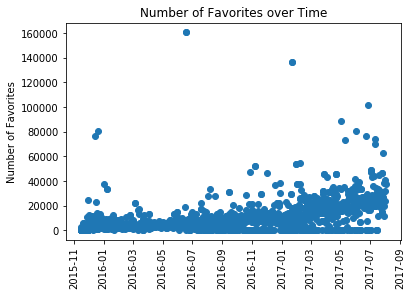

In [367]:
dates = matplotlib.dates.date2num(twitter_archive_master.timestamp)
plt.plot_date(dates, (twitter_archive_master.favorite_count))
plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 90)
plt.title('Number of Favorites over Time')
plt.ylabel('Number of Favorites');

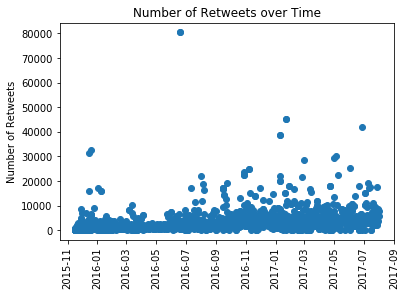

In [370]:
dates = matplotlib.dates.date2num(twitter_archive_master.timestamp)
plt.plot_date(dates, (twitter_archive_master.retweet_count))
plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 90)
plt.title('Number of Retweets over Time')
plt.ylabel('Number of Retweets');

From the graph of favorites over datetime, a visible increase in the amount of favorites is noticeable as an overall trend. Although the same does not to be as strongly the case with retweets, as the dispersion is much greater, one can also say that retweets are much more committal than favorites and thus will show fewer numbers and more variance (this is just speculation). One might argue that this is caused by an overall rise in the accounts popularity, causing any posts at near the latter half of the sample to recieve a greater number of favorites and retweets.

Regardless of the reason, the lack of a uniform distribution, at least from a visual analysis, suggests that the timing of a date does not have a non-zero effect on the amount of favorites. This can have large consequences when looking in hindsight at the previous analysis. For instance, although labrador retrievers and golden retrievers were breeds with an outstanding number of retweets and favorites, even after weighting, it is possible that a greater portion of them were taken near the latter half of the sampling period, leading to an inflated number of favorites and retweets. Thus, a more accurate future analysis could probably take the timing of these posts into account, perhaps in a similar manner of weighting the tweets, or by binning them to similar time periods.

#### Citations
Defining Kindchenschema:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3260535/

American Kennel Club Dog Rankng stats:
https://www.akc.org/expert-advice/news/most-popular-dog-breeds-of-2018/